This notebook will create gene lists used to build networks. To build the gene lists I will take all pairs of subclasses and compute constituitievely expressed genes within those 2 subclasses within each dataset and then use the recurrent list to build Cluster, Subclass and Class label networks.

It also includes the pseudobulk analysis


## Imports

In [1]:
import numpy as np
import pandas as pd
import gc
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product


from scipy import spatial, cluster
import joypy

from egad import run_egad
import pymn
from rank import rank

In [2]:
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

In [3]:
#These save characters as text in PDFs
import matplotlib
from move_seaborn_legend import move_legend
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [4]:
import sys
sys.path.append('/home/bharris/biccn_paper/scripts/')

import load_pearson_networks

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Functions

In [22]:
def read_markers(subclass):
    subclass = subclass.replace('_', '.')
    return pd.read_csv(
        f'/tyronedata/fischer/de_lists/{subclass}_markers_de.txt',
        index_col=0,
        comment='#',
        delimiter=' ')

In [23]:
def create_empty_network(genes):
    return np.zeros([genes.shape[0], genes.shape[0]])

In [24]:
def aggregate_networks(datasets, level, genes_name, genes):
    nws_path = '/home/bharris/biccn_paper/data/subclass_pairs_analysis/networks/'
    agg_nw = create_empty_network(genes)
    for dataset in datasets:
        if dataset == 'macosko_10x_nuc_v3':
            nw = pd.read_hdf(
                f'{nws_path}macosko_MOp_v3_gene_list_{genes_name}_{level}_aggregated.hdf5',
                'nw')
        else:
            nw = pd.read_hdf(
                f'{nws_path}{dataset}_object_gene_list_{genes_name}_{level}_aggregated.hdf5',
                'nw')
        agg_nw += nw.values
        del nw
        gc.collect()
    rank(agg_nw)
    return pd.DataFrame(agg_nw, index=genes, columns=genes)

In [25]:
def get_marker_dummies(selected_genes, min_auroc = .6):
    top_markers = all_markers[all_markers.gene.isin(
        selected_genes)].sort_values(
            ['subclass', 'recurrence', 'average_auroc'],
            ascending=[True, False, False
                       ]).groupby('subclass').head(100).reset_index(drop=True)
    top_markers = top_markers.query(f'average_auroc >= {min_auroc}')
    marker_dummies = pd.get_dummies(
        top_markers.set_index('gene')['subclass']).reset_index().groupby(
            'gene').sum().reindex(selected_genes).fillna(0)
    return marker_dummies

## Load Data

In [6]:
dataset_dict = pd.read_csv(
    '/home/bharris/biccn_paper/data/dataset_dict_biccn_sets_7.csv',
    index_col=0).to_dict()

In [7]:
subclass_recurrence = pd.read_csv(
    '/home/bharris/biccn_paper/data/subclass_recurrence.csv', index_col=0)
subclass_recurrence.drop(['Meis2', 'Sst_Chodl'], inplace=True)

In [8]:
subclass_pairs = list(
    filter(
        lambda t: t[0] < t[1],
        product(subclass_recurrence.index.values,
                subclass_recurrence.index.values)))

In [9]:
all_genes = np.genfromtxt(
    '/home/bharris/biccn_paper/data/all_dataset_shared_genes.txt', dtype=str)

In [10]:
# Build dictionary to store recurrence (subclass1, subclass2) : pd.DataFrame(index=genes,columns=shared_datasets)
genes_recurrence = {}
for subclass1, subclass2 in subclass_pairs:
    shared_datasets = (subclass_recurrence.loc[subclass1]
                       & subclass_recurrence.loc[subclass2]).index
    genes_recurrence[(subclass1,
                      subclass2)] = pd.DataFrame(0,
                                                 index=all_genes,
                                                 columns=shared_datasets)

In [11]:
go_mouse = pd.read_hdf('/home/bharris/GO_data/go_mouse_nw.hdf5', 'go')

go_slim = np.genfromtxt('/home/bharris/GO_data/aug4.GOslim', dtype=str)

go_mouse_slim = go_mouse[np.intersect1d(go_mouse.columns, go_slim)]

In [12]:
gist_earth = sns.color_palette('gist_earth', 3)

gist_earth[0] = 'k'


## Select Genes for Networks

In [ ]:
# for dataset in dataset_dict:
#     logging.info(dataset)
#     fn = dataset_dict[dataset]['andata']
#     adata = sc.read(fn)
#     adata = adata[
#         adata.obs.class_label.isin(['GABAergic', 'Glutamatergic']), :]
#     adata = adata[:, all_genes]
#     for subclass1, subclass2 in subclass_pairs:
#         logging.info((subclass1, subclass2))
#         if not (subclass_recurrence.loc[subclass1, dataset]
#                 & subclass_recurrence.loc[subclass2, dataset]):
#             continue
#         adata_subclass = adata[adata.obs.subclass_label.isin(
#             [subclass1, subclass2])]
#         detection = np.ravel((adata_subclass.X > 0).sum(axis=0)) / adata_subclass.shape[0]
#         genes_recurrence[(subclass1, subclass2)][dataset] = detection

#     del adata, adata_subclass
#     gc.collect()

In [ ]:
# all_selected_genes = pd.DataFrame(index=all_genes)
# for subclass1, subclass2 in subclass_pairs:
#     selected_genes = (genes_recurrence[(subclass1, subclass2)] > .25).sum(
#         axis=1) >= (genes_recurrence[(subclass1, subclass2)].shape[1] - 2)
#     all_selected_genes.loc[all_genes[selected_genes.values],
#                            f'{subclass1}_{subclass2}'] = 1
# all_selected_genes.fillna(0, inplace=True)

In [ ]:
for dataset in dataset_dict:
    logging.info(dataset)
    fn = dataset_dict[dataset]['andata']
    adata = sc.read(fn)
    adata = adata[
        adata.obs.class_label.isin(['GABAergic', 'Glutamatergic']), :]
    adata = adata[:, all_genes]
    for subclass1, subclass2 in subclass_pairs:
        logging.info((subclass1, subclass2))
        if not (subclass_recurrence.loc[subclass1, dataset]
                & subclass_recurrence.loc[subclass2, dataset]):
            continue
        adata_subclass = adata[adata.obs.subclass_label.isin(
            [subclass1, subclass2])]
        detection = np.mean(adata_subclass.to_df().values, axis=0)
        genes_recurrence[(subclass1, subclass2)][dataset] = detection
    del adata, adata_subclass
    gc.collect()

In [ ]:
all_selected_genes = pd.DataFrame(index=all_genes)
for subclass1, subclass2 in subclass_pairs:
    selected_genes = all_genes[genes_recurrence[(subclass1, subclass2)].rank(
        ascending=False).mean(axis=1).rank(ascending=True) <= 4201]
    all_selected_genes.loc[selected_genes, f'{subclass1}_{subclass2}'] = 1
all_selected_genes.fillna(0, inplace=True)

In [ ]:
jaccard_selected_genes = all_selected_genes.T @ all_selected_genes



In [ ]:
jac = spatial.distance.squareform(
    spatial.distance.pdist(all_selected_genes.values.T, metric='jaccard'))

In [ ]:
l = pymn.compute_nw_linkage(pd.DataFrame(1-jac))
sns.clustermap(1 - jac,
               cmap='coolwarm',
               vmin=0,
               vmax=1,
               row_linkage=l,
               col_linkage=l)

In [ ]:
clustered_lists = pd.concat([
    pd.Series(cluster.hierarchy.fcluster(l, 10, criterion='maxclust'),
              index=all_selected_genes.columns),
    all_selected_genes.sum()
],
                            axis=1)
clustered_lists.columns=['Cluster','Size']

In [ ]:
selected_clusters = clustered_lists.groupby('Cluster').agg(['idxmax', 'max'])['Size']
np.savetxt(
    '/home/bharris/biccn_paper/data/subclass_pairs_analysis/selected_subclass_pairs.csv',
    selected_clusters['idxmax'].values,
    fmt='%s')

In [ ]:
file_names = []
for col in selected_clusters['idxmax'].values:
    fn = f'/home/bharris/biccn_paper/data/subclass_pairs_analysis/gene_list_{col}.csv'
    np.savetxt(fn, all_genes[all_selected_genes[col].astype(bool)], fmt='%s')
    file_names.append(fn)
np.savetxt(
    f'/home/bharris/biccn_paper/data/subclass_pairs_analysis/gene_list_file_names.csv',
    file_names,
    fmt="%s")

In [ ]:
sns.clustermap(1 - spatial.distance.squareform(
    spatial.distance.pdist(
        all_selected_genes[selected_clusters['idxmax'].values].values.T,
        metric='jaccard')),
            cmap='coolwarm',
            vmin=0,
            vmax=1,
            annot=True,
            annot_kws={'fontsize': 7})
plt.show()

## Evaluate Networks

In [22]:
selected_cluster = np.genfromtxt(
    '/home/bharris/biccn_paper/data/subclass_pairs_analysis/selected_subclass_pairs.csv',
    dtype=str)

### Compute Performance for existing publication

In [67]:
normal_markers = pd.read_csv(
    '/home/bharris/biccn_paper/data/stephan_marker_nw.csv', index_col=0)
normal_markers.drop(['GABAergic', 'Glutamatergic', 'Non.Neuronal'],
                    axis=1,
                    inplace=True)

In [19]:
pearson_nws = load_pearson_networks.load_all_networks()

2020-12-28 11:51:39,986 - zeng_10x_cell
2020-12-28 11:52:04,995 - zeng_10x_nuc
2020-12-28 11:52:30,313 - zeng_smart_cell
2020-12-28 11:52:55,079 - zeng_smart_nuc
2020-12-28 11:53:19,875 - zeng_10x_cell_v3
2020-12-28 11:53:45,083 - zeng_10x_nuc_v3
2020-12-28 11:54:11,205 - macosko_10x_nuc_v3


In [20]:
cl_norm = run_egad(normal_markers, pearson_nws['class_label']['aggregate'])
cl_norm['level'] = "class_label"

scl_norm = run_egad(normal_markers, pearson_nws['subclass_label']['aggregate'])
scl_norm['level'] = "subclass_label"

jcl_norm = run_egad(normal_markers,
                    pearson_nws['joint_cluster_label']['aggregate'])
jcl_norm['level'] = "joint_cluster_label"
normal_performance = pd.concat([cl_norm, scl_norm, jcl_norm])
normal_performance['genes_size'] = pearson_nws['joint_cluster_label'][
    'aggregate'].shape[0]

norm_performance = normal_performance.groupby('level').mean().reset_index()[[
    'level', 'AUC', 'genes_size'
]]
norm_performance['list_type'] = 'Highly Expressed'

### Compute performance using new markers

In [24]:
all_marker_performances = pd.read_csv(
    '/home/bharris/biccn_paper/data/subclass_pairs_analysis/agg_nws_markers_perf.csv.gz',
    index_col=0)

avg_auroc = all_marker_performances.groupby(['gene_list', 'level'
                                             ])['AUC'].mean().reset_index()

In [25]:
avg_auroc.groupby('level').mean().rename({
    'joint_cluster_label': 'cluster_label'
}).iloc[[0, 2, 1]]

,AUC
level,
class_label,0.871690
subclass_label,0.689813
cluster_label,0.659769


In [27]:
avg_auroc['list_type'] = 'Subclass Pair'

subclass_performance = pd.concat([avg_auroc, norm_performance])

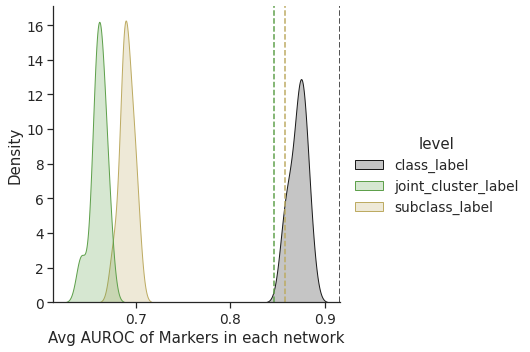

In [41]:
g = sns.displot(avg_auroc,
                x='AUC',
                hue='level',
                kind='kde',
                fill=True,
                palette=gist_earth)
for i in range(3):
    g.ax.axvline(norm_performance.iloc[i, 1], c=gist_earth[i], ls='--')
g.set_xlabels('Avg AUROC of Markers in each network')
plt.savefig(
    '/home/bharris/biccn_paper/figures/resub/two_subclass_markers_perf.pdf',
    transparent=True)

## Evaluate GO performance on the networks


### Compute Performance for exisitng Networks

In [32]:
c_go_norm = run_egad(go_mouse_slim, pearson_nws['class_label']['aggregate'])
c_go_norm['level'] = "class_label"

sc_go_norm = run_egad(go_mouse_slim,
                      pearson_nws['subclass_label']['aggregate'])
sc_go_norm['level'] = "subclass_label"

jc_go_norm = run_egad(go_mouse_slim,
                      pearson_nws['joint_cluster_label']['aggregate'])
jc_go_norm['level'] = "joint_cluster_label"
normal_go_performance = pd.concat([c_go_norm, sc_go_norm, jc_go_norm])
normal_go_performance['genes_size'] = pearson_nws['joint_cluster_label'][
    'aggregate'].shape[0]

norm_go_perf = normal_go_performance.groupby('level').mean().reset_index()[[
    'level', 'AUC', 'genes_size'
]]
norm_go_perf['list_type'] = 'Highly Expressed'

### Compute performance for new networks

In [34]:
all_go_performances = pd.read_csv(
    '/home/bharris/biccn_paper/data/subclass_pairs_analysis/agg_nws_go_perf.csv.gz',
    index_col=0)

In [35]:
avg_go = all_go_performances.groupby(['gene_list', 'level']).mean()['AUC'].reset_index()

avg_go['list_type'] = 'Subclass Pair'

In [36]:
avg_go.groupby('level').mean().rename({
    'joint_cluster_label': 'cluster_label'
}).iloc[[0, 2, 1]]

,AUC
level,
class_label,0.592067
subclass_label,0.591336
cluster_label,0.588926


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tranparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


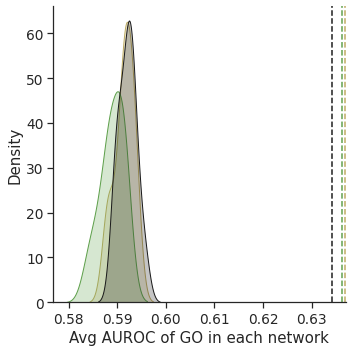

In [40]:
g = sns.displot(avg_go,
                x='AUC',
                hue='level',
                kind='kde',
                fill=True,
                palette=gist_earth,
                legend=False)
for i in range(3):
    g.ax.axvline(norm_go_perf.iloc[i, 1], c=gist_earth[i], ls='--')
g.set_xlabels('Avg AUROC of GO in each network')
plt.savefig('/home/bharris/biccn_paper/figures/resub/two_subclass_GO_perf.pdf',
            tranparent=True)

## Pseudobulk test (Supplementary Figure 4)

In [15]:
df = pd.concat([
    pd.read_csv(
        f'/home/bharris/biccn_paper/data/pseudobulk/pseudo_bulk_egad_res_{i}.csv.gz',
        index_col=0) for i in range(1,101)
])

In [16]:
df.groupby('reference').mean()

,AUC,AVG_NODE_DEGREE,DEGREE_NULL_AUC,P_Value,run_id
reference,,,,,
GO,0.562980,2085.627261,0.516984,0.058082,50.5
Markers,0.869174,2084.792269,0.434783,0.000092,50.5


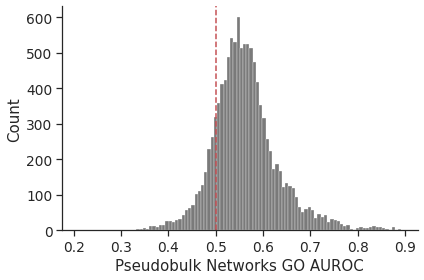

In [55]:
ax = sns.histplot(df[df.reference == 'GO'].AUC, bins=100, color='.3')
ax.axvline(.5, ls='--', c='r')
ax.set(xlabel='Pseudobulk Networks GO AUROC')
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/resub/pseduobulk_GO.pdf',
            transparent=True)

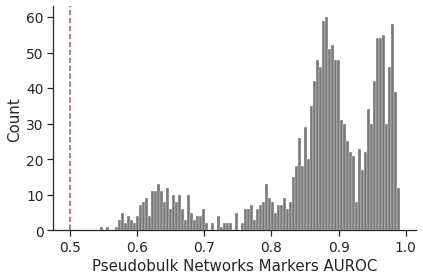

In [57]:
ax = sns.histplot(df[df.reference == 'Markers'].AUC, bins=100, color='.3')
ax.axvline(.5, ls='--', c='r')
ax.set(xlabel='Pseudobulk Networks Markers AUROC')
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/resub/pseduobulk_Markers.pdf',
            transparent=True)